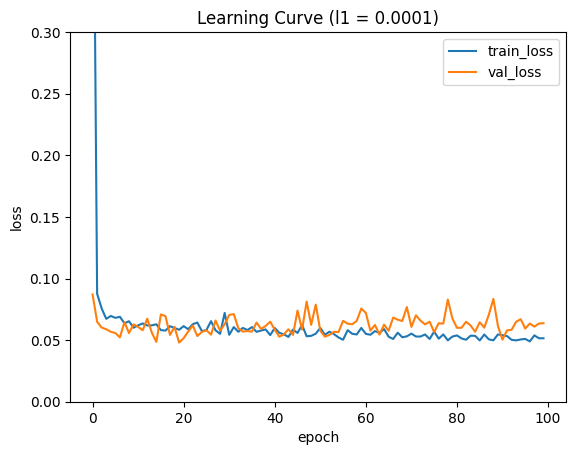

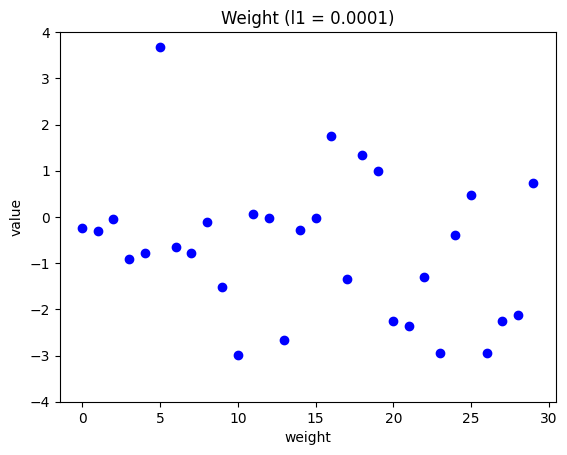

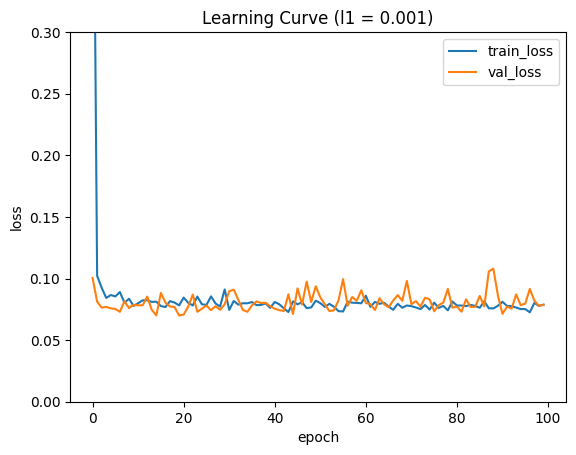

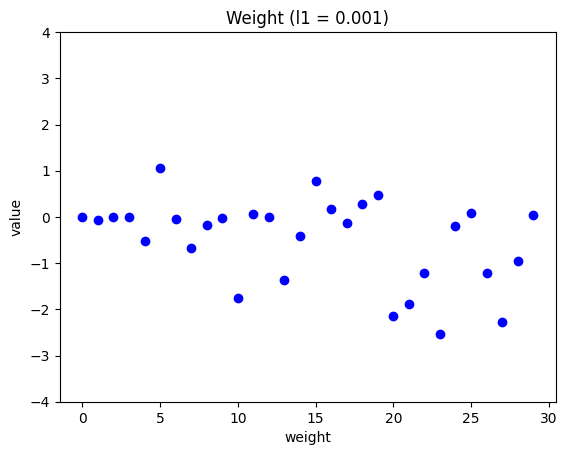

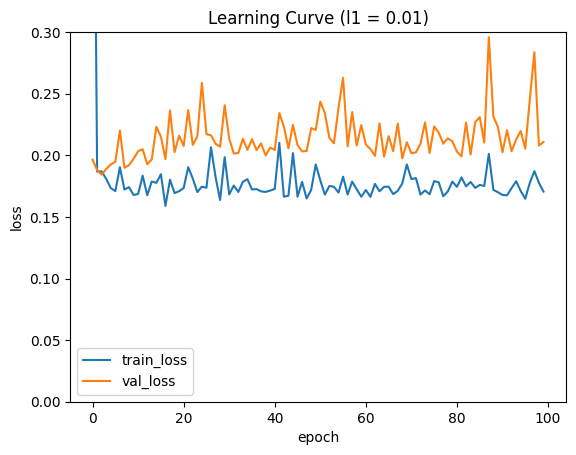

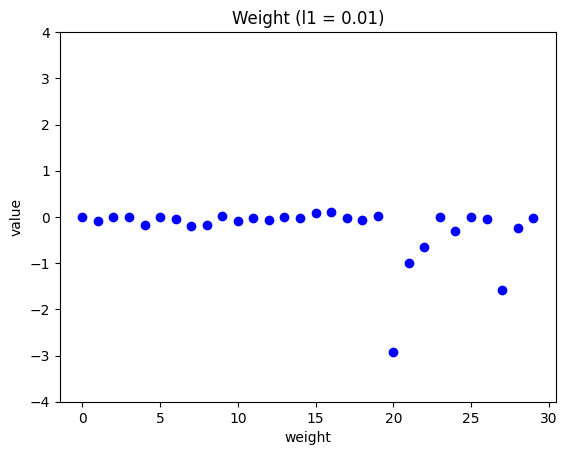

0.978021978021978

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

cancer = load_breast_cancer()

x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify = y, test_size = 0.2, random_state = 42)

x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size = 0.2, random_state = 42)

train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std

val_mean = np.mean(x_train, axis=0)
val_std = np.std(x_train, axis=0)
x_val_scaled = (x_val - val_mean) / val_std

class SingleLayer:

  def __init__(self, learning_rate = 0.1, l1 = 0, l2 = 0):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x):
    z = np.sum(x * self.w) + self.b
    return z
  
  def backprop(self, x, err):
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad

  def activation(self ,z):
    z = np.clip(z, -100, None)
    a = 1 / (1 + np.exp(-z))
    return a

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    self.w = np.ones(x.shape[1])
    self.b = 0
    self.w_history.append(self.w.copy())
    np.random.seed(42)
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x)))
      for i in indexes:
        z = self.forpass(x[i])
        a = self.activation(z)
        err = -(y[i] - a)
        w_grad, b_grad = self.backprop(x[i], err)
        w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
        self.w -= self.lr * w_grad
        self.b -= b_grad
        self.w_history.append(self.w.copy())
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += -(y[i] * np.log(a) + (1 - y[i]) * np.log(1 - a))
      self.losses.append(loss/len(y) + self.reg_loss())
      self.update_val_loss(x_val, y_val)

  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x]
    return np.array(z) > 0

  def score(self, x, y):
    return np.mean(self.predict(x) == y)
  
  def update_val_loss(self, x_val, y_val):
    if x_val is None:
      return
    val_loss = 0
    for i in range(len(x_val)):
      z = self.forpass(x_val[i])
      a = self.activation(z)
      a = np.clip(a, 1e-10, 1-1e-10)
      val_loss += -(y_val[i] * np.log(a) + (1-y_val[i]) * np.log(1-a))
    self.val_losses.append(val_loss / len(y_val) + self.reg_loss())

  def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
  lyr = SingleLayer(l1 = l1)
  lyr.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val)

  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve (l1 = {})'.format(l1))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'val_loss'])
  plt.ylim(0, 0.3)
  plt.show()

  plt.plot(lyr.w, 'bo')
  plt.title('Weight (l1 = {})'.format(l1))
  plt.ylabel('value')
  plt.xlabel('weight')
  plt.ylim(-4, 4)
  plt.show()

layer5 = SingleLayer(l1 = 0.001)
layer5.fit(x_train_scaled, y_train, epochs=20)
layer5.score(x_val_scaled, y_val)

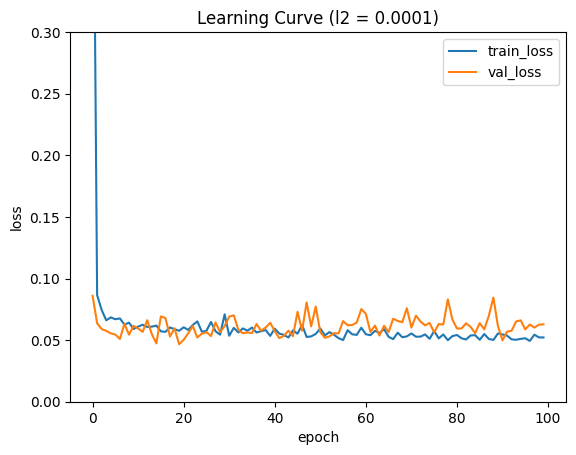

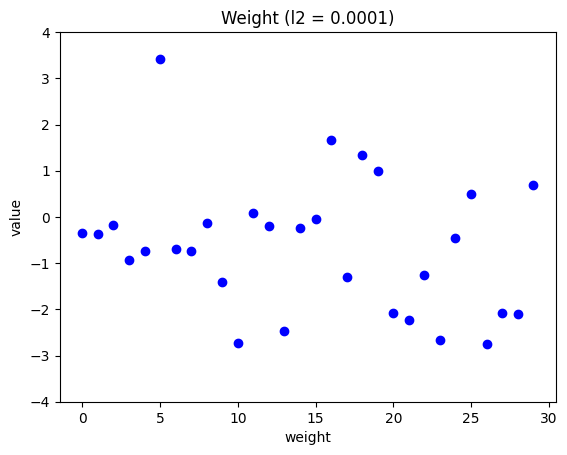

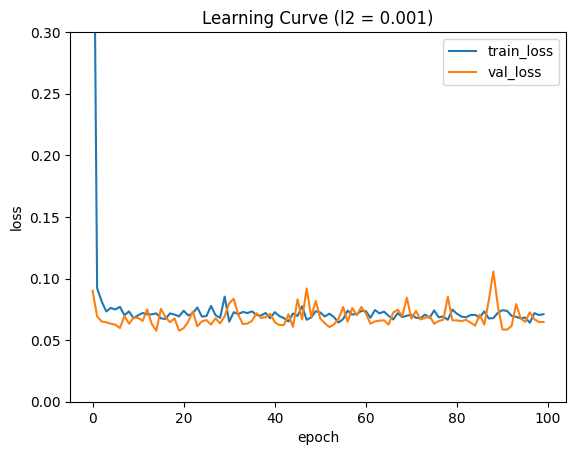

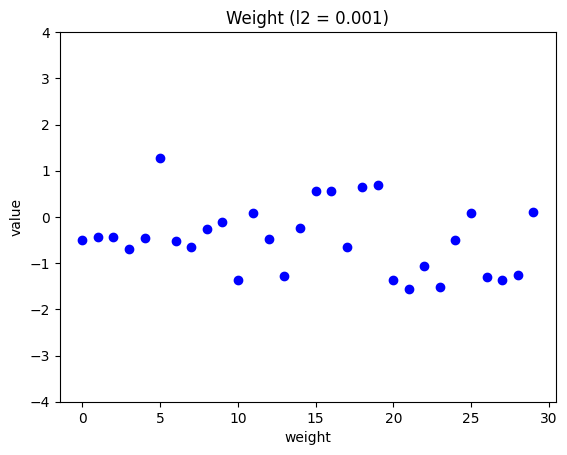

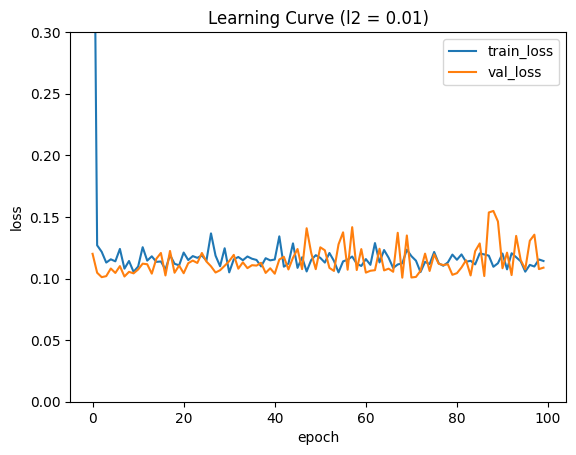

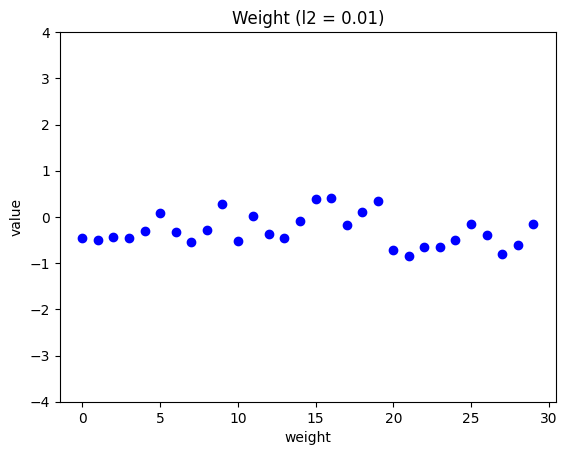

0.978021978021978

In [11]:
l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
  lyr = SingleLayer(l2 = l2)
  lyr.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val)

  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve (l2 = {})'.format(l2))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'val_loss'])
  plt.ylim(0, 0.3)
  plt.show()

  plt.plot(lyr.w, 'bo')
  plt.title('Weight (l2 = {})'.format(l2))
  plt.ylabel('value')
  plt.xlabel('weight')
  plt.ylim(-4, 4)
  plt.show()

layer6 = SingleLayer(l2 = 0.01)
layer6.fit(x_train_scaled, y_train, epochs=50)
layer6.score(x_val_scaled, y_val)

In [13]:
np.sum(layer6.predict(x_val_scaled) == y_val)

sgd = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.001, random_state=42)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)

0.978021978021978

In [22]:
validation_scores = []
k = 10
bins = len(x_train_all) // k

for i in range(k):
  start = i * bins
  end = (i+1) * bins
  val_fold = x_train_all[start:end]
  val_target = y_train_all[start:end]

  train_index = list(range(0, start)) + list(range(end, len(x_train)))
  train_fold = x_train_all[train_index]
  train_target = y_train_all[train_index]

  train_mean = np.mean(train_fold ,axis=0)
  train_std = np.std(train_fold, axis=0)
  train_fold_scaled = (train_fold - train_mean) / train_std
  val_fold_scaled = (val_fold - train_mean) / train_std

  lyr = SingleLayer(l2 = 0.01)
  lyr.fit(train_fold_scaled, train_target, epochs=50)
  score = lyr.score(val_fold_scaled, val_target)
  validation_scores.append(score)

print(np.mean(validation_scores))

0.9711111111111113


In [17]:
from sklearn.model_selection import cross_validate
sgd = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.001, random_state=42)
scores = cross_validate(sgd, x_train_all, y_train_all, cv = 10)
print(np.mean(scores['test_score']))

0.850096618357488


In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(StandardScaler(), sgd)
scores = cross_validate(pipe, x_train_all, y_train_all, cv=10, return_train_score=True)
print(np.mean(scores['test_score']))

0.9694202898550724


In [20]:
print(np.mean(scores['train_score']))

0.9875478561631581
